In [273]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, UTC
from sqlalchemy.orm import Session

from ionbeam.core.time import (
    TimeSpan,
    collapse_time_spans_upto_max,
    split_df_into_time_chunks,
)

def plot_spans(spans, ax = None, shade_colour = "green", label = None):
    if ax is None: f, ax = plt.subplots(1, 1, figsize = (10, 2))
    
    for ts in spans:
            ax.axvline(ts.start, linestyle = "dotted", color = "green")
            ax.axvline(ts.end, linestyle = "solid", color = "orange")
            ax.axvspan(ts.start, ts.end, alpha = 0.1, color = shade_colour, label = label)
    return ax

In [275]:
import logging 

logging.basicConfig(
    level=logging.DEBUG,
)
import matplotlib
matplotlib.pyplot.set_loglevel("warning")

In [276]:
from ionbeam.sources.API_sources_base import DataChunk, DBDataChunk, DataStream
from ionbeam.core import parse_single_action, parse_config
from pathlib import Path

config_file = Path("~/git/IonBeam_bundle/IonBeam/config").expanduser()

action_yaml = """
class: AcronetSource
mappings: []
"""

config, source = parse_single_action(config_file, action_yaml, 
                        offline = False,
                        environment  = "local",
                        die_on_error = False,
                                    )

DEBUG:ionbeam.core.config_parser.config_parser:Configuration Directory: /Users/math/git/IonBeam_bundle/IonBeam/config
DEBUG:ionbeam.core.config_parser.config_parser:Global config file: /Users/math/git/IonBeam_bundle/IonBeam/config/config.yaml
DEBUG:ionbeam.core.config_parser.config_parser:Loaded global config...
DEBUG:ionbeam.core.config_parser.config_parser:Resolved config.globals.data_path to /Users/math/git/IonBeam_bundle/data
DEBUG:ionbeam.core.config_parser.config_parser:Resolved config.globals.cache_path to /Users/math/git/IonBeam_bundle/data/cache
DEBUG:ionbeam.core.config_parser.config_parser:Resolved config.globals.fdb_schema_path to /Users/math/git/IonBeam_bundle/IonBeam/config/schema
DEBUG:ionbeam.core.config_parser.config_parser:Resolved config.globals.fdb_root to /Users/math/git/IonBeam_bundle/data/fdb_root
DEBUG:ionbeam.core.config_parser.config_parser:Resolved config.globals.metkit_language_template to /Users/math/git/IonBeam_bundle/IonBeam/config/language.yaml.template


In [277]:
from pprint import pprint

now = datetime.now(UTC)

show_time_span = TimeSpan.last(days = 1)

query_time_span = show_time_span

data_streams = list(source.get_data_streams(show_time_span))

# data_streams = data_streams[:4]

for ds in data_streams:
    pprint(ds)

DataStream(source='acronet',
           key='acronet:PLUVIOMETRO',
           version=1,
           data=GenericSensor(unit='mm',
                              name='PLUVIOMETRO',
                              translation='RAIN_GAUGE'),
           last_ingestion=None)
DataStream(source='acronet',
           key='acronet:TERMOMETRO',
           version=1,
           data=GenericSensor(unit='°C',
                              name='TERMOMETRO',
                              translation='TEMPERATURE'),
           last_ingestion=None)
DataStream(source='acronet',
           key='acronet:IGROMETRO',
           version=1,
           data=GenericSensor(unit='%',
                              name='IGROMETRO',
                              translation='HYGROMETER'),
           last_ingestion=None)
DataStream(source='acronet',
           key='acronet:DIREZIONEVENTO',
           version=1,
           data=GenericSensor(unit='Degrees',
                              name='DIREZIONEVENTO',
        

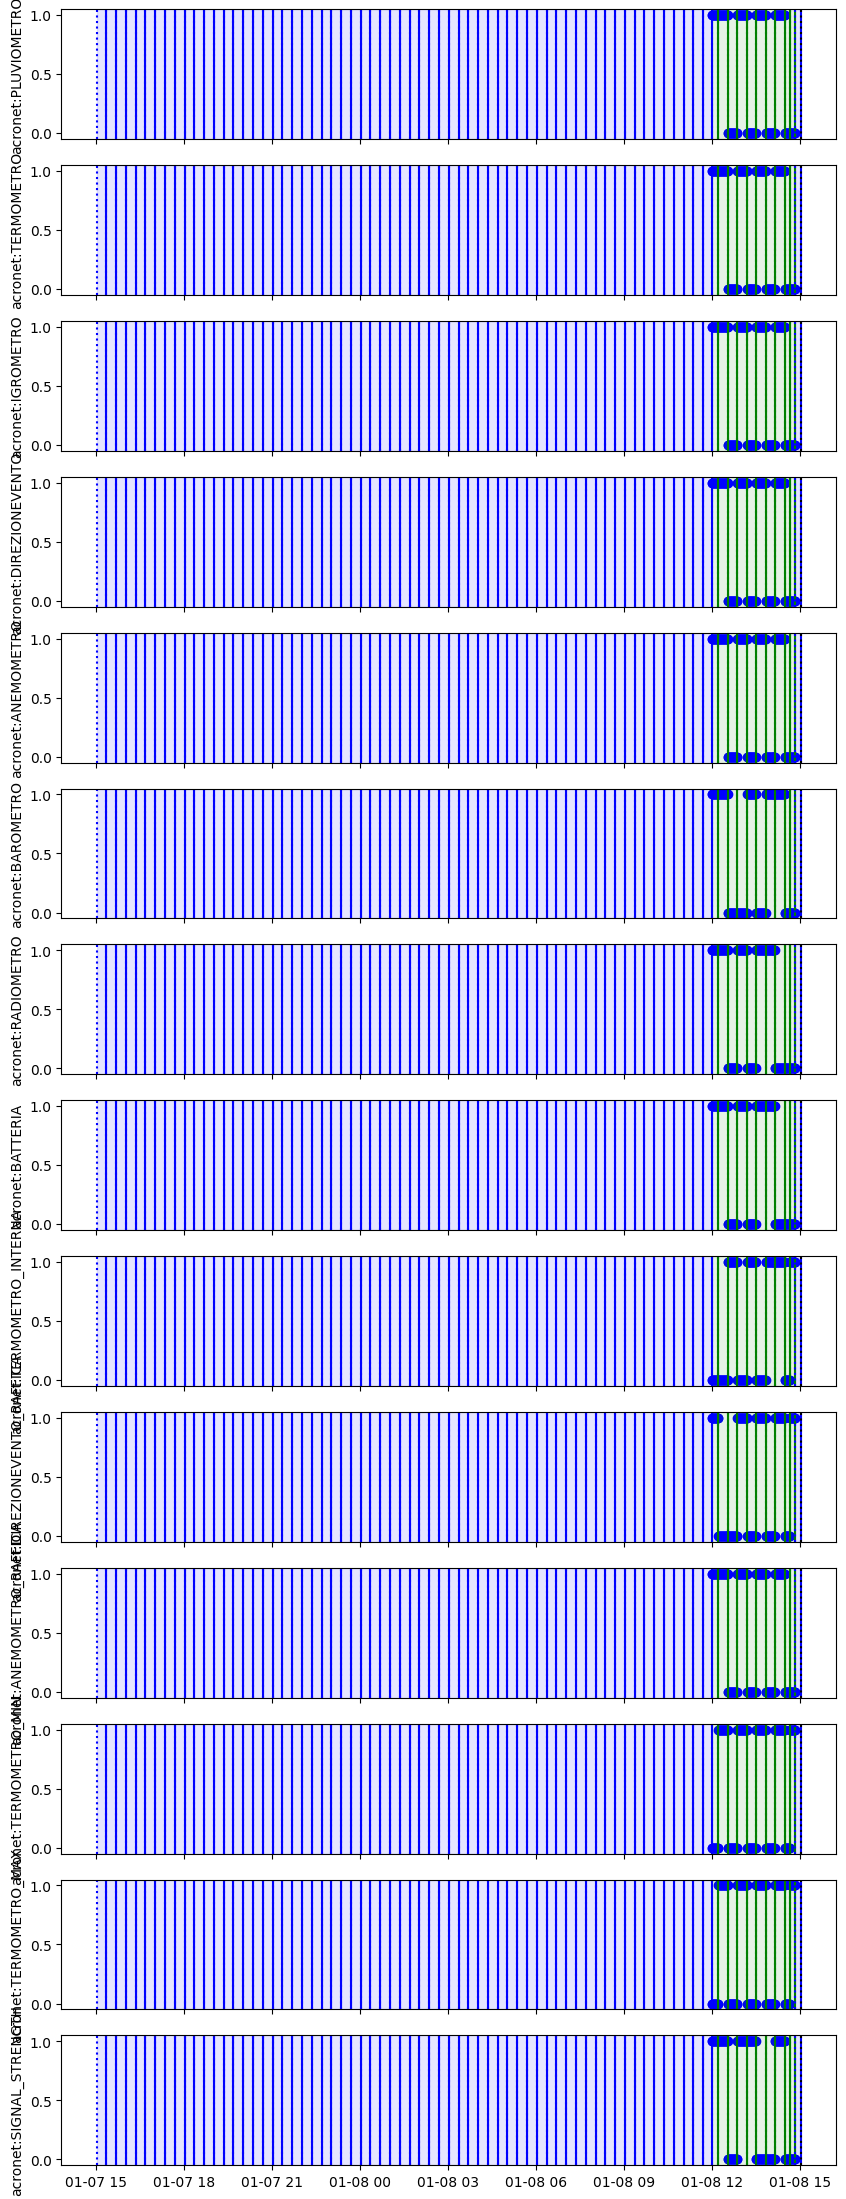

In [278]:
def plot_datastreams():

    n = len(data_streams)
    f, axes = plt.subplots(n, 1, figsize = (10, 2*n), sharex = True)
    
    def plot_timespan(ax, ts, colour, label = None):
        ax.axvline(ts.start, linestyle = "dotted", color = colour)
        ax.axvline(ts.end, linestyle = "solid", color = colour)
        ax.axvspan(ts.start, ts.end, alpha = 0.1, color = colour, label = label)
    
    with Session(config.globals.sql_engine) as db_session:
        for ds, ax in zip(data_streams, axes):
            existing_chunks = ds.get_chunks_from_db(db_session, show_time_span)
            
            for i, chunk in enumerate(existing_chunks):
                if not chunk.success:
                    pprint(chunk)
                colour = "red" if not chunk.success else "green"
                label = "Failed" if not chunk.success else "Sucess"
                plot_timespan(ax, chunk.time_span, colour, label = label)

                times = set(datetime.strptime(t, "%Y%m%d%H%M")
                            for readings in chunk.json
                            for t in readings["timeline"])
                ax.scatter(y = [i%2 for _ in times],  x = list(times), color = "blue")
            
            gaps = source.gaps_in_database(db_session, ds, query_time_span)
            for ts in gaps: 
                # print(f"gap: {ts.delta()}")
                plot_timespan(ax, ts, "blue", label = "Todo")
    
            ax.axvline(datetime.now(UTC), linestyle = "dotted", color = "k")
            ax.set(ylabel = ds.key)
    # ax.legend()

plot_datastreams()

In [279]:
import requests
from requests.structures import CaseInsensitiveDict

# Create a Response object
response = requests.Response()

# Populate response with desired status code and headers
response.status_code = 429
response.reason = "Too Many Requests"
response.headers = CaseInsensitiveDict({"Retry-After": "60"})

# Construct the HTTPError using the response
too_many_requsts_error = requests.exceptions.HTTPError(
    f"{response.status_code} {response.reason}",
    response=response
)

In [280]:
# downloaded_chunks = list(source.download_data(data_streams, query_time_span, 
#                                               # fail = too_many_requsts_error
#                                              ))

In [281]:
# plot_datastreams()

In [282]:
# with Session(config.globals.sql_engine) as db_session:
#     for dc in db_session.query(DBDataChunk).all():
#         db_session.delete(dc)
#     db_session.commit()

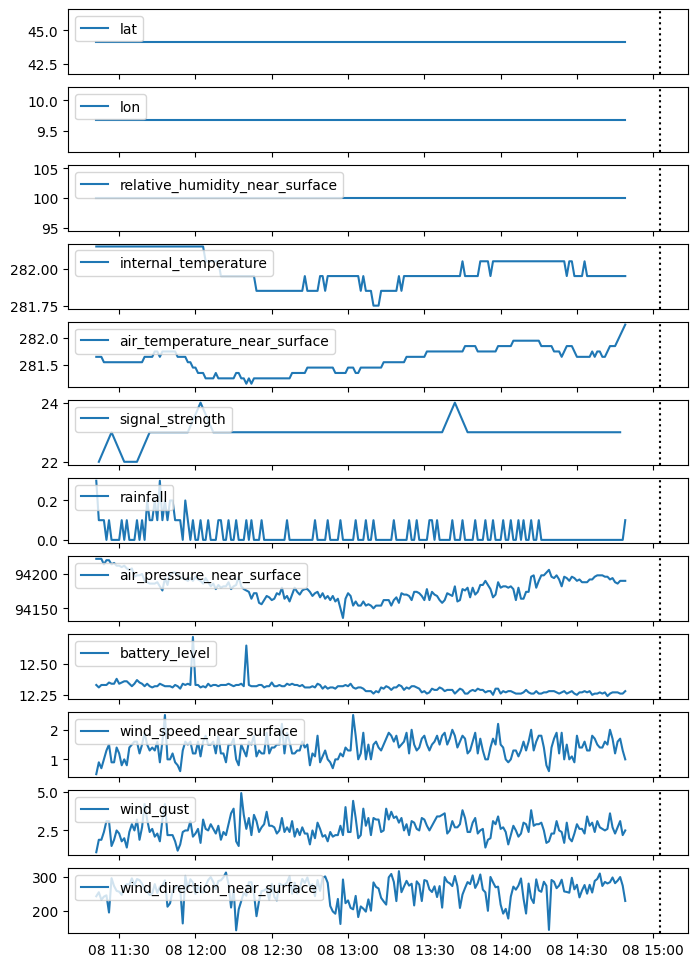

In [285]:
from io import BytesIO
import pandas as pd

show_granule_boundaries = False

url = "http://localhost:5002/api/v1/"
session = requests.Session()
station = next(s for s in session.get(url + "stations").json() if s["platform"] == "acronet")

now = datetime.now(UTC)
args = {
    "start_time" : (now - timedelta(days = 3)).isoformat(),
    "end_time": (now - timedelta(hours = 0)).isoformat(),
}

granules = session.get(url + "list", params = station["mars_request"] | args).json()
data = session.get(url + "retrieve", params = station["mars_request"] | args | dict(format = "csv"))

if not data.ok:
    print("error: ", data.json())
else:
    df = pd.read_csv(BytesIO(data.content))



df["datetime"] = pd.to_datetime(df["datetime"])

ys_to_plot = df.select_dtypes(include='number').columns


f, axes = plt.subplots(len(ys_to_plot), 1,  figsize=(8, 1*len(ys_to_plot)), sharex=True)

for y, ax in zip(ys_to_plot, axes):
    mask = ~df[y].isnull()
    ax.plot(df["datetime"][mask], df[y][mask], label = y)
    ax.legend(loc = 2)
    
    if show_granule_boundaries:
        for g in granules:
            date, time = g["mars_request"]["date"], g["mars_request"]["time"]
            dt = datetime.strptime(date + time, "%Y%m%d%H%M")
            dt2 = dt + timedelta(minutes = 20)
            ax.axvline(dt, linestyle = "dotted", color = "green")
            ax.axvline(dt2, linestyle = "dotted", color = "green")
            ax.axvspan(dt, dt2, alpha = 0.1, color = "green")

    ax.axvline(datetime.now(UTC), linestyle = "dotted", color = "black")

    # for d in example_station["time_span"].values():
    #     ax.axvline(datetime.fromisoformat(d), linestyle = "dotted", color = "black")

    # ax.axvline(args["start_time"], linestyle = "dotted", color = "red")
    # ax.axvline(args["end_time"], linestyle = "dotted", color = "red")

In [284]:
df

,station_id,station_name,author,datetime,lat,lon,rainfall,air_temperature_near_surface,relative_humidity_near_surface,wind_direction_near_surface,wind_speed_near_surface,air_pressure_near_surface,battery_level,internal_temperature,wind_gust,signal_strength
0,vvf_brugnato,VVF Brugnato,acronet,2025-01-08 11:59:00+00:00,44.23795,9.728625,0.0,283.550001,0.1,160.60000,0.7,100310.000,12.540000,292.15,1.1,NaN
1,vvf_brugnato,VVF Brugnato,acronet,2025-01-08 12:00:00+00:00,44.23795,9.728625,0.1,283.550001,0.1,177.90001,0.7,100313.995,12.540000,293.15,1.0,NaN
2,vvf_brugnato,VVF Brugnato,acronet,2025-01-08 12:01:00+00:00,44.23795,9.728625,0.0,283.550001,0.1,186.80000,0.7,100316.000,12.530000,293.15,1.0,NaN
3,vvf_brugnato,VVF Brugnato,acronet,2025-01-08 12:02:00+00:00,44.23795,9.728625,0.1,283.450000,0.1,178.90001,0.9,100316.000,12.520000,293.15,1.2,21.0
4,vvf_brugnato,VVF Brugnato,acronet,2025-01-08 12:03:00+00:00,44.23795,9.728625,0.1,283.450000,0.1,186.70000,0.6,100312.000,12.509999,293.15,1.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,vvf_brugnato,VVF Brugnato,acronet,2025-01-08 14:45:00+00:00,44.23795,9.728625,0.0,284.050001,0.1,135.10000,0.9,100330.000,12.219999,292.15,1.6,NaN
167,vvf_brugnato,VVF Brugnato,acronet,2025-01-08 14:46:00+00:00,44.23795,9.728625,0.0,283.950000,0.1,178.50000,0.8,100324.000,12.200000,293.15,1.2,NaN
168,vvf_brugnato,VVF Brugnato,acronet,2025-01-08 14:47:00+00:00,44.23795,9.728625,0.0,283.950000,0.1,128.70000,0.8,100318.000,12.219999,293.15,1.2,21.0
169,vvf_brugnato,VVF Brugnato,acronet,2025-01-08 14:48:00+00:00,44.23795,9.728625,0.1,283.950000,0.1,105.50000,2.1,100313.995,12.219999,293.15,3.6,NaN
